In [3]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dataretrieval
import hydrofunctions
#import pygeohydro
#import ulmo
#import wellapplication

import pastas

In [4]:
os.getcwd()

'/home/mlr/Desktop/hydro-tools'

## hydrofunctions

In [ ]:
dir(hydrofunctions)
help(hydrofunctions)
hydrofunctions.__version__

In [6]:
fox_river_gb_dv = hydrofunctions.NWIS("040851385", "dv", period="P10D")
print(fox_river_gb_dv)
print(len(fox_river_gb_dv.df().index))

# this is a handy method to look at the response code, maybe useful
print(fox_river_gb_dv.response.url)

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040851385&period=P10D
USGS:040851385: FOX RIVER AT OIL TANK DEPOT AT GREEN BAY, WI
    00010: <Day>  Temperature, water, degrees Celsius 
    00060: <Day>  Discharge, cubic feet per second 
    00095: <Day>  Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius 
    00300: <Day>  Dissolved oxygen, water, unfiltered, milligrams per liter 
    00400: <Day>  pH, water, unfiltered, field, standard units 
    63680: <Day>  Turbidity, water, unfiltered, monochrome near infra-red LED light, 780-900 nm, detection angle 90 +-2.5 degrees, formazin nephelometric units (FNU) 
Start: 2021-10-24 00:00:00+00:00
End:   2021-11-03 00:00:00+00:00
11
https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=040851385&period=P10D


In [ ]:
fox_river_gb_iv = hydrofunctions.NWIS("040851385", "iv", period="P10D")
print(fox_river_gb_iv)
print(len(fox_river_gb_iv.df().index))
print(fox_river_gb_iv.response)

In [ ]:
fox_river_gb_iv = hydrofunctions.NWIS("040851385", "iv", "2021-10-15", "2021-10-25")
print(fox_river_gb_iv)
print(len(fox_river_gb_iv.df().index))
print(fox_river_gb_iv.response)

In [ ]:
fox_river_gb_iv.df()

In [ ]:
wi_code = "WI"
wi = hydrofunctions.NWIS(stateCd=wi_code)
type(wi)

In [ ]:
dir(wi)

In [ ]:
help(hydrofunctions.NWIS)

## python dataretrieval

In [ ]:
help(dataretrieval)
print(dir(dataretrieval))
#dataretrieval.__version__

In [ ]:
# dataretrivel is broken into modules, need to import individual pieaces as needed
from dataretrieval import nwis, utils

# refernence gage, time, and data
fox_river_gb = "040851385"
start = "2021-10-10"
end = "2021-10-20"
data = ["iv", "dv", "qwdata", "site"]

# attempt to get iv, dv, site, and qwdata... raise error if data does not exist
for d in data:
    try:
        nwis.get_record(sites=fox_river_gb, service=d, start=start, end=end).info()
        print("-"*20)

    except utils.NoSitesError as e:
        print(f"{d}: {e}")
        print("-"*20)

In [47]:
# use specific dataretrieval functions to get data, these follow R dataRetrieval style
from dataretrieval import nwis

# refernence gage, time, and data
fox_river_gb = "040851385"
start = "2021-10-15"
end = "2021-10-25"

# returns a tuple with dataframe and metadata class
dv = nwis.get_dv(start=start, end=end, sites=fox_river_gb)
iv = nwis.get_iv(start=start, end=end, sites=fox_river_gb)
info = nwis.get_info(sites=fox_river_gb)

In [55]:
print(type(dv[1]))
print(type(dv[1].url))
print(dv[1].url)

<class 'dataretrieval.utils.Metadata'>
<class 'str'>
https://waterservices.usgs.gov/nwis/dv?format=json&startDT=2021-10-15&endDT=2021-10-25&sites=040851385


In [ ]:
# pull out metadata class and look at attributes, can't remember a better way to print
meta_info = info[1]
print(meta_info.comment)
print(meta_info.disclaimer)
print(meta_info.header)
print(meta_info.query_time)
print(meta_info.site_info)
print(meta_info.statistic_info)
print(meta_info.url)
print(meta_info.variable_info)

In [ ]:
type(dv)
for i in dv:
    print(type(i))

In [ ]:
type(iv)
for i in dv:
    print(type(i))

In [ ]:
type(info)
for i in info:
    print(type(i))

In [ ]:
iv[0].head()

In [ ]:
# pull out info dataframe and transpose
df_info = info[0]
df_info.T.head()

In [ ]:
from dataretrieval import nwis
codes = nwis.get_pmcodes()
codes

## test returned data

looking at data returned by hydrofunctions and dataretrieval from a fixed stream gage. how close are the timeseries for a given channel? do the date time indexes align?

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import dataretrieval
import hydrofunctions

from datetime import datetime, timedelta
from dataretrieval import nwis


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

# parameter codes
temp_c = "00010"       # temp celsius
discharge_q = "00060"  # cubic feet per second
gage_height = "00065"  # height


def get_data(gage, data, start, end):
    '''
    retrieve data with hydrofunctions, get request url, get dataframe of discharge, convert datetime to CDT
    
    retrieve data with dataretrieval, get request url, query with discharge parameter code, get dataframe tuple
    
    return 2 dataframes and 2 request urls
    '''
    # get NWIS object, make time zone aligned discharge dataframe from json, grab response url
    hf = hydrofunctions.NWIS(fox_river_gb, data, start, end, verbose=False)
    hf_data = hf.df("discharge").tz_convert('US/Central')
    hf_response = f"hydrofunctions:\n {hf.response.url}"
    
    # get tuple object of discharge dataframe and metedata with response url
    dt_data, dt_meta = nwis.get_iv(start=start, end=end, sites=fox_river_gb, parameterCd="00060")
    dt_response = f"python-dataretrieval:\n {dt_meta.url}"
    
    return hf_data, hf_response, dt_data, dt_response


def compare_urls(*response):
    '''
    helper to print response urls
    '''
    for i in response:
        print(i)


def obs_summary(hf_df, dt_df, start, end, data):
    '''
    print number of 5 minute observations expected over a time period
    
    print the total number of observations returned from hydrofunctions and dataretrieval
    
    print number of missing or extra observations and equivalent time relative to expected observations
    '''
    
    perhour = 60/5
    perday = 24*perhour
    perperiod = 10*perday

    hf_length = len(hf_df.index)
    dt_length = len(dt_df.index)
    hf_diff = hf_length-perperiod
    dt_diff = dt_length-perperiod
    
    print(f"observations: 10days = {perperiod}, 1day= {perday}, 1hour= {perhour}")
    print("-"*50)
    print(f"hydrofunctions {data} data from {start} to {end}: {hf_length} observations")
    print(f"dataretrieval {data} data from {start} to {end}: {dt_length} observations")
    print("-"*50)
    print(f"hydrofunctions difference: {abs(hf_diff)} observations, {hours(hf_diff, perhour)} {text(hf_diff)}")
    print(f"dataretrieval difference: {abs(dt_diff)} observations, {hours(dt_diff, perhour)} {text(dt_diff)}")


def text(diff):
    '''
    helper for obs_summary()
    '''
    return "extra hours of observations" if diff >= 0 else "missing hours of observations"


def hours(diff, perhour):
    '''
    helper for obs_summary()
    '''
    return abs(round(diff/perhour, 2))


def check_gaps(df):
    '''
    find datetime gaps in returned data
    
    print start and stop time for gaps and total duration 
    '''
    
    # TODO try/except for no gap case
    
    # grab datetime index, run diff on datetimes, drop index row 0 NA
    dt_index_delta = dt_df.reset_index()["datetime"].diff()[1:]

    # delta between continous timesteps should be 5 minutes, filter for a timedelta greater than 5 minutes
    dt_gaps = dt_index_delta[dt_index_delta > timedelta(minutes=5)]

    # print results 
    print(f'{len(dt_gaps)} gaps with total duration: {dt_gaps.sum()}')
    for i, g in dt_gaps.iteritems():
        gap_start = dt_df.reset_index()["datetime"][i - 1]
        gap_stop = dt_df.reset_index()["datetime"][i]
        # TODO make shorter
        print(f"Start: {datetime.strftime(gap_start, '%Y-%m-%d %H:%M:%S')} | Stop: {datetime.strftime(gap_stop, '%Y-%m-%d %H:%M:%S')} | Duration: {str(g.to_pytimedelta())}")


def get_gaps(df):
    '''
    get the indexes for start and stop times for all gaps
    
    use gap indexes to mask dataframe of all observations
    
    return masked dataframe of time gaps
    '''
    
    # convert index to array, compute time diff, drops first index due to diff algro 
    np_delta = np.diff(df.index.to_numpy())

    # insert dummy diff at index 0 to align indexes
    np_delta = np.insert(np_delta, 0, np_delta[0])

    # get boolean mask for timedelta over 5 minutes
    np_mask = np_delta > timedelta(minutes=5)

    # set index 1 back from first gap to true
    np_mask[np.where(np_mask==True)[0][0]-1] = True

    # filter original dataframe with mask to extract datetime gaps and return
    return df[np_mask]


def make_plot(df, gaps, title):
    '''
    plot returned data and time gaps for missing data
    '''
    plt.figure(figsize=(20, 10))
    plt.title(f"{title}: {start} to {end}")
    plt.scatter(df.index, df.iloc[:, 0], s=5)
    plt.axvline(df.index[0], color="black", linestyle="--", linewidth=2)
    plt.axvline(df.index[-1], color="black", linestyle="--", linewidth=2)
    for i in gaps.index.to_list():
        plt.axvline(i, color="red")
    plt.show()    

In [12]:
# refernence gage, time, and data
fox_river_gb = "040851385"
data = "iv"
start = "2021-10-15"
end = "2021-10-25"

In [13]:
hf_df, hf_response, dt_df, dt_response = get_data(gage=fox_river_gb, data=data, start=start, end=end)

In [14]:
compare_urls(hf_response, dt_response)

hydrofunctions:
 https://waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=040851385&startDT=2021-10-15&endDT=2021-10-25
python-dataretrieval:
 https://waterservices.usgs.gov/nwis/iv?format=json&startDT=2021-10-15&endDT=2021-10-25&sites=040851385&parameterCd=00060


In [15]:
obs_summary(hf_df=hf_df, dt_df=dt_df, start=start, end=end, data=data)

observations: 10days = 2880.0, 1day= 288.0, 1hour= 12.0
--------------------------------------------------
hydrofunctions iv data from 2021-10-15 to 2021-10-25: 3168 observations
dataretrieval iv data from 2021-10-15 to 2021-10-25: 2783 observations
--------------------------------------------------
hydrofunctions difference: 288.0 observations, 24.0 extra hours of observations
dataretrieval difference: 97.0 observations, 8.08 missing hours of observations


In [16]:
check_gaps(dt_df)

5 gaps with total duration: 1 days 08:30:00
Start: 2021-10-19 19:20:00 | Stop: 2021-10-19 20:25:00 | Duration: 1:05:00
Start: 2021-10-21 12:15:00 | Stop: 2021-10-21 13:00:00 | Duration: 0:45:00
Start: 2021-10-21 13:00:00 | Stop: 2021-10-22 01:00:00 | Duration: 12:00:00
Start: 2021-10-22 01:00:00 | Stop: 2021-10-22 13:00:00 | Duration: 12:00:00
Start: 2021-10-22 13:00:00 | Stop: 2021-10-22 19:40:00 | Duration: 6:40:00


In [17]:
dt_gaps = get_gaps(dt_df)
dt_gaps

,00060_2,00060_2_cd,site_no
datetime,,,
2021-10-19 19:20:00-05:00,1640.0,P,040851385
2021-10-19 20:25:00-05:00,8460.0,P,040851385
2021-10-21 13:00:00-05:00,3810.0,P,040851385
2021-10-22 01:00:00-05:00,3810.0,P,040851385
2021-10-22 13:00:00-05:00,3530.0,P,040851385
2021-10-22 19:40:00-05:00,8770.0,P,040851385


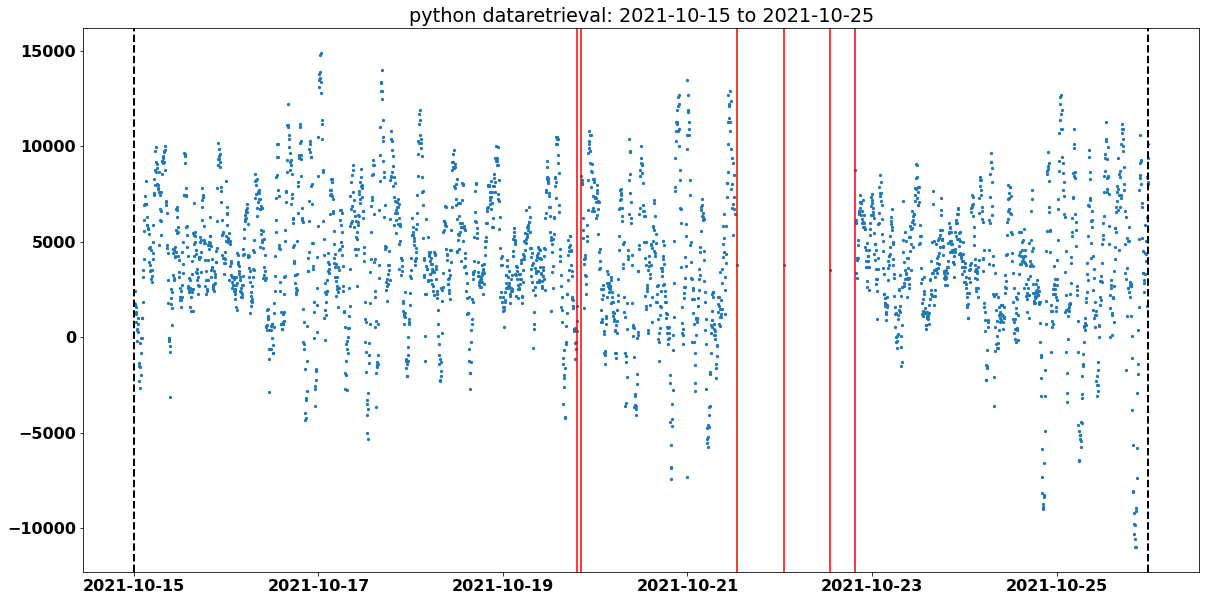

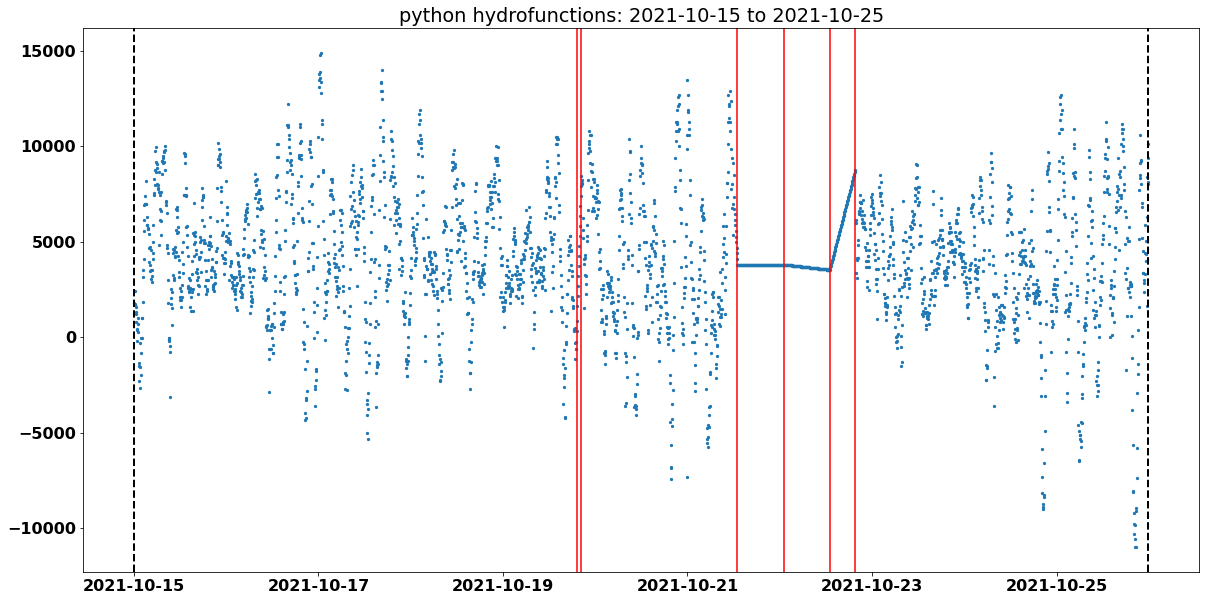

In [18]:
make_plot(dt_df, dt_gaps, title="python dataretrieval")
make_plot(hf_df, dt_gaps, title="python hydrofunctions")

## integration example

fit curve and interpolate over missing data with scipy and/or pastas